![Image of Yaktocat](logo.jpg)

# Sample Starting Kit
# HADACA: Identifying cancer stages based on tumor heterogeneity

## Multiclass classification using a factorized methylation matrix

This code was tested with
Python 3.6.6 - Anaconda custom (64-bit) - (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)

<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.

<div>
    <h2>Introduction </h2>
    <p>
This dataset is a small set of patients which have been diagnotised at different stages of cancer. Your task is to improve the classification results regarding the stages of those patients (read the whole notebook for details). The data is a matrix of <i>(number of patients) lines * (number of features per patient) columns </i>. The features correspond to methylation information related to the medical condition of each patient.
    </p>
</div>

# Table of contents

## Step 1: Exploratory data analysis

Understand the data, represented by the matrix D, which you will use to get another matrix with smaller dimensions to achieve a classification in cancer stages in Step 2 (check associated cells for additional details).

## Step 2: Building a predictive model
Experimenting with a little data sample and a weak baseline model to understand your task. Note that the factorization is already done in /sample_code_submission/model.py and that the poor results depicted in the confusion matrix are normal for so few data in training (check associated cells for additional details).
### 2.1) Training a predictive model after the factorization
### 2.2) Results
### 2.3) Factorization example and associated evaluation with RMSE
## Step 3: Making a submission




In [1]:
import matplotlib.pyplot as plt
import pandas as pd

model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div >
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit to make this notebook work and illustrative, but to prepare your submission and realize actual experiments, you must fetch the public_data from the challenge website. Only using the whole training set, you will be able to achieve interesting classification results, and eventually improve our weak baseline.
</p>
</div>

In [2]:
data_dir = 'sample_data'              # Change this to the directory where you put the input data
#data_dir = '../FILES/iris/'          # The sample_data directory should contain only a very small subset of the data
data_name = 'hadaca'
#!ls $data_dir*
!dir $data_dir*                     # For Windows users

/bin/sh: dir: command not found


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

Reading sample_data/hadaca_train from AutoML format
Number of examples = 100
Number of features = 5000
          Class
0      stage ib
1      stage ia
2       stage i
3     stage iib
4      stage iv
5    stage iiia
6  not reported
7     stage iia
8           Nan
9    stage iiib
Number of classes = 10


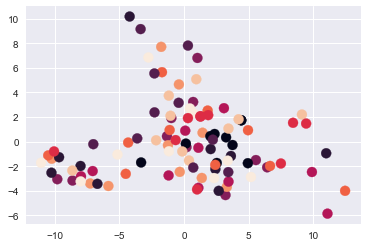

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)       # The data are loaded as a Pandas Data Frame
# because we have a huge number of features wo only chose some for visualization
# We use PCA in order to reduce the dimension
# We only use 2 principal components
from sklearn.decomposition import PCA
data_slice = PCA(n_components=2).fit_transform(data.loc[:,~data.columns.str.contains('^target$')].values)
target_revers_index = {value: key for key, value in enumerate(set(data['target'].values))}
plt.scatter(data_slice[:,0], data_slice[:,1], c=[target_revers_index[t] for t in data['target'].values], s=100)
data_slice = pd.DataFrame({'component_1':data_slice[:,0],'component_2':data_slice[:,1], 'target':data['target'].values})

In [4]:
data_slice.head()

,component_1,component_2,target
0,6.428927,-2.090842,stage ib
1,-0.976435,1.917482,stage ib
2,3.209365,-4.351127,stage ib
3,0.708326,3.226246,stage ib
4,0.192163,-0.453879,stage ib


In [5]:
set(list(data_slice.target))

{'Nan',
 'not reported',
 'stage i',
 'stage ia',
 'stage ib',
 'stage iia',
 'stage iib',
 'stage iiia',
 'stage iiib',
 'stage iv'}

In [6]:
data_slice.describe() 

,component_1,component_2
count,1.000000e+02,1.000000e+02
mean,2.842171e-16,1.315614e-16
std,5.215416e+00,3.137966e+00
min,-1.104494e+01,-5.862050e+00
25%,-2.403687e+00,-2.364625e+00
50%,5.848421e-01,-5.548594e-01
75%,3.220584e+00,1.842551e+00
max,1.245374e+01,1.018061e+01


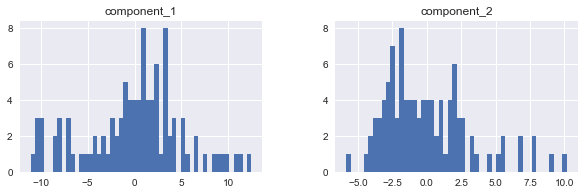

In [7]:
data_slice.hist(figsize=(10, 10), bins=50, layout=(3, 2));

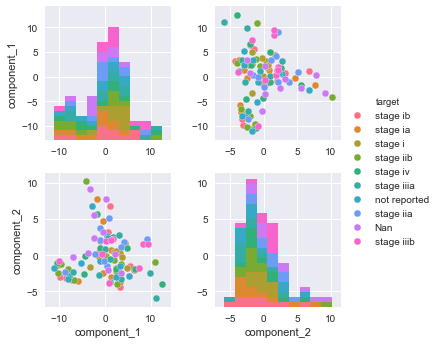

In [8]:
sns.pairplot(data_slice, hue="target")

<div>
<h1>Step 2: Building a predictive model</h1>
</div>

## 2.1) Training a predictive model after the factorization

The factorization of the original data matrix D is already realized in the model.py (cf. "from model import model"). A cell at the end of this notebook still shows how we accomplish this factorization, and suggests RMSE to observe the quality of this operation.

Note that the factorization is fundamental if you want to be able to compute your classification on your laptop. **This factorization projects the 5000 original features of the initial matrix D in n_components (parameter of the TruncatedSVD function), which makes the data used for model training substantially smaller.** If for some reason you still want to heat up your laptop, feel free to try the classification directly on the initial D matrix :p !

In [9]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)

Info file found : /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data/hadaca_public.info


Note that the model provided for this notebook (and used in the cell below) isn't optimized in order to return the best possible results, this is your data scientist mission ! **As such, you should think about changing parameters and models, be creative ! Your contribution to this task is to modify the /sample_code_submission/model.py source code to get the best possible results according to the chosen metrics** (see the end of this notebook).

In [10]:
from model import model
M1 = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)           

In [11]:
import numpy as np

X_train = D.data['X_train']
Y_train = D.data['Y_train'].ravel()

X_valid = D.data['X_valid']
Y_valid = D.data['Y_valid'].ravel()

X_test = D.data['X_test']
Y_test = D.data['Y_test'].ravel()

if not(M1.is_trained) or True:
    M1.fit(X_train, Y_train)       
    
Y_hat_train_facto = M1.predict(X_train) # Optional, not really needed to test on taining examples
Y_hat_valid_facto = M1.predict(X_valid)
Y_hat_test_facto = M1.predict(X_test)

FIT: dim(X)= [100, 10]
FIT: dim(y)= [100, 1]
PREDICT: dim(X)= [100, 10]
PREDICT: dim(y)= [100, 1]
PREDICT: dim(X)= [100, 10]
PREDICT: dim(y)= [100, 1]
PREDICT: dim(X)= [100, 10]
PREDICT: dim(y)= [100, 1]


In [12]:
M1.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train_facto)
write(result_name + '_valid.predict', Y_hat_valid_facto)
write(result_name + '_test.predict', Y_hat_test_facto)
#!ls $result_name*

## 2.2) Results

We choose the scoring metric. Pay attention to its definition, understanding it specifically in the case of multiclass classification is essential to appreciating your results.

The results for sample_data, especially the confusion matrix, aren't to look good: this notebook tries to achieve machine learning with very few data, so you should expect bad results here. The results you will eventually get with the whole training set should (will !) be much better.

Finally, don't hesitate to use the visualization tools at your disposal. Swimming among thousands of thousands of parameters without them is completely impossible.

In [13]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: precision_score


In [14]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, Y_hat_test_facto))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the precision_score metric = 0.2969
Ideal score for the precision_score metric = 1.0000


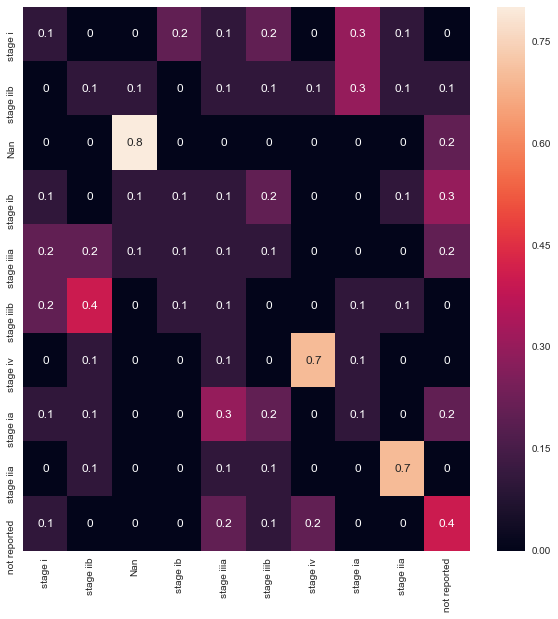

In [15]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred1 = Y_hat_test_facto
y_test1 = Y_test
array = confusion_matrix(y_test1, y_pred1)
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]


df_cm = pd.DataFrame(array, index = set(list(data.target)) , columns = set(list(data.target)))
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.show()

In [16]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(M1, D.data['X_test'], Y_test, cv=cv, scoring=make_scorer(scoring_function))

print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [70, 10]
FIT: dim(y)= [70, 1]
PREDICT: dim(X)= [30, 10]
PREDICT: dim(y)= [30, 1]
FIT: dim(X)= [70, 10]
FIT: dim(y)= [70, 1]
PREDICT: dim(X)= [30, 10]
PREDICT: dim(y)= [30, 1]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


FIT: dim(X)= [70, 10]
FIT: dim(y)= [70, 1]
PREDICT: dim(X)= [30, 10]
PREDICT: dim(y)= [30, 1]
FIT: dim(X)= [70, 10]
FIT: dim(y)= [70, 1]
PREDICT: dim(X)= [30, 10]
PREDICT: dim(y)= [30, 1]
FIT: dim(X)= [70, 10]
FIT: dim(y)= [70, 1]
PREDICT: dim(X)= [30, 10]
PREDICT: dim(y)= [30, 1]

CV score (95 perc. CI): 0.30 (+/- 0.17)


## 2.3) Factorization example and associated evaluation with RMSE

As it is said in a previous comment cell, the factorization is already done in model.py (cf. "from model import model"). Still, it can be interesting to understand how we achieved it, and how to parametrize it.

You could try to change the factorization parameters (like n_components of TruncatedSVD) directly in the model.py source code. This way, you can evaluate the evolution of your classification in relation with the evolution of the RMSE (see below), the latter translating how good your factorization actually is.

In [17]:
from sklearn.metrics import  mean_squared_error
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 10)

A_test = svd.fit_transform(X_test)
#A_test = svd.fit_transform(X_test)

T = svd.components_
print(A_test.shape)
print(T.shape)
D_matrix = np.dot(A_test,T)
print(D_matrix.shape)
################ WARNING ###############
# pearson = np.corrcoef(D,X_art)
# print("Pearson =", pearson) 
########################################

rmse = mean_squared_error(D_matrix,X_test)
print("RMSE =", rmse)

(100, 10)
(10, 5000)
(100, 5000)
RMSE = 0.00722349704694


<div >
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [18]:
!python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data
Using output_dir: /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_result_submission
Using program_dir: /Users/lucgibaud/Desktop/H/HADACA/starting_kit/ingestion_program
Using submission_dir: /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Hadaca ********
************************************************
========= Reading and converting data ==========
Info file found : /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data/hadaca_public.info
========= Reading /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data/hadaca_feat.type
[+] Success in  0.00 sec
========= Reading /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data/hadaca_train.data
[+] Success in  0.66 sec
========= Reading /Users/lucgibaud/Desktop/H/HADACA/starting_kit/sample_data/had

<div >
Also test the scoring program:
    </div>

In [19]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

======= Set 1 (Hadaca_test): precision_score(set1_score)=0.296879509380 =======
======= Set 2 (Hadaca_train): precision_score(set2_score)=0.930151515152 =======
======= Set 3 (Hadaca_valid): precision_score(set3_score)=0.382131398014 =======


<div >
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [20]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip'
sample_result_submission = 'sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
sample_code_submission_18-12-14-21-58.zip
sample_result_submission_18-12-14-21-58.zip
